In [1]:
# Preamble

from astropy.table import Table, column
import numpy as np
import os

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True

In [2]:
import sys
sys.path.append('../../../astro_codes/')
#------------------------------------

In [3]:
#gz_data = Table.read('../matched_fits/gz_data.fits')
a70_data = Table.read('../matched_fits/a70_matched.fits')
nsa_data = Table.read('../matched_fits/nsa_matched.fits')
samples = Table.read('../matched_fits/samples.fits')

In [4]:
import astropy.units as u

def mass_limit_from_redshift(z):
    K = 2.356e5*((3e5/70)**2) # constant for converting between flux and mass
    mass_limit = np.log10(K*(z**2)*0.72)
    return mass_limit


def redshift_limit_from_mass(mass):
    K = 2.356e5*((3e5/70)**2) # constant for converting between flux and mass
    z_limit = (10**mass/(0.72*K))**(1/2)
    return z_limit

def redshift_from_dist(D):
    return (70/3e5)*D

/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log10


/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):
/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


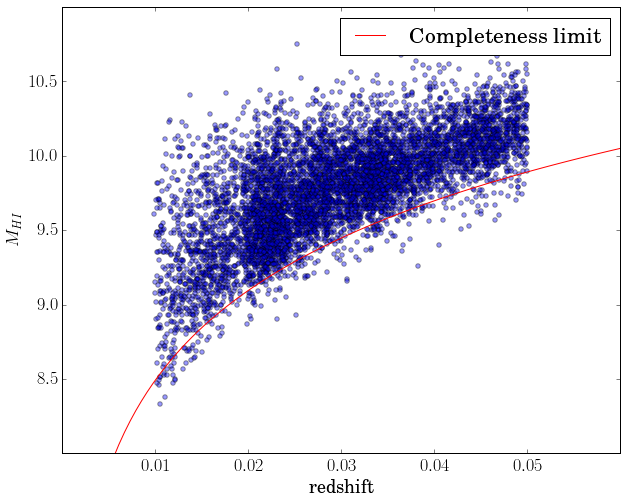

In [5]:
has_a70 = (a70_data['mask']) & (nsa_data['mask']) & (nsa_data['Z'] <= 0.05)
 
_ = plt.scatter(nsa_data['Z'][has_a70],a70_data['loghimass'][has_a70],alpha=0.4)

z_guide = np.linspace(0,0.06,100)
_ = plt.plot(z_guide,mass_limit_from_redshift(z_guide),'r-',label='Completeness limit')
plt.axis((0,0.06,8,11))
plt.xlabel('redshift')
plt.ylabel('$M_{HI}$')
plt.legend()

In [6]:
#calculate the vmax limit for each detection?

in_vmax = ((a70_data['loghimass'] >= mass_limit_from_redshift(nsa_data['Z'])) &
           (nsa_data['Z'] >= 0.02) & (nsa_data['Z'] <= 0.05))


def get_vmax_weights(mass,high_z=0.05,low_z=0.02,mask=None,weighting=True):
    
    vmax_weighting = np.zeros(len(mass))
    redshift_limits = redshift_limit_from_mass(mass)
    redshift_limits[redshift_limits > high_z] = high_z
    vmax = redshift_limits**3 - low_z**3
    
    if mask is not None:
        vmax[mask == False] = -999
    
    if weighting is True:
        vmax_weighting = 1/vmax
        min_vmax_weighting = np.min(vmax_weighting[mask])
        vmax_weighting = vmax_weighting/min_vmax_weighting
        vmax_weighting[mask == False] = -999
        return vmax_weighting, redshift_limits
    else:
        return vmax, redshift_limits

In [7]:
vmax_weights, zmax = get_vmax_weights(a70_data['loghimass'],mask=in_vmax)

delta_z = zmax*0.5*(1/a70_data['snratio'])
ok_z = delta_z <= 5*(zmax-0.02)

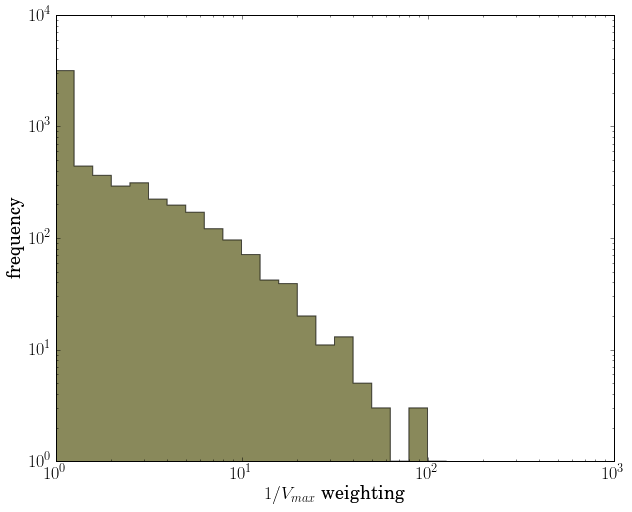

In [8]:
_ = plt.hist(vmax_weights,bins=np.logspace(0,3,31),color='y',alpha=0.4,histtype='stepfilled')
_ = plt.hist(vmax_weights[ok_z],bins=np.logspace(0,3,31),color='k',alpha=0.4,histtype='stepfilled')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$1/V_{max}$ weighting')
plt.ylabel('frequency')

## Now calculate the 'expected' gas fractions?

In [9]:
chang_data = Table.read('../matched_fits/chang_out_matched.fits')

In [10]:
vmax_both = (in_vmax) & (samples['in_vmax_limit'])
weighting_both = np.max(np.array([vmax_weights,samples['mass_weighting']]).T, axis=1)

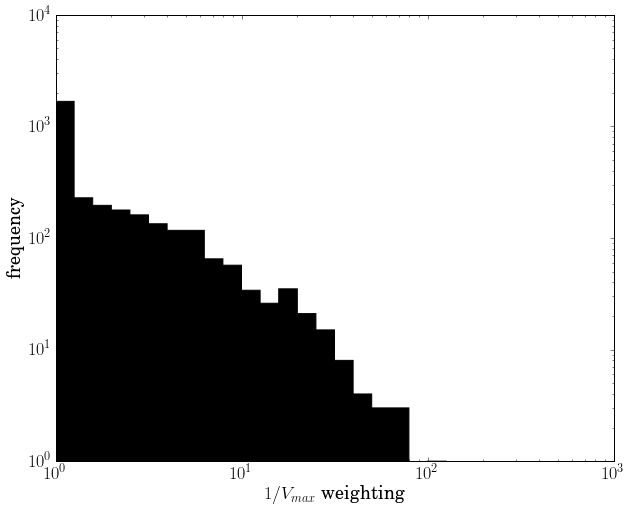

In [11]:
_ = plt.hist(weighting_both[vmax_both],bins=np.logspace(0,3,31),color='k',alpha=1,histtype='stepfilled')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('$1/V_{max}$ weighting')
plt.ylabel('frequency')

/home/ppxrh/anaconda3/lib/python3.4/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype >f8 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
../../../astro_codes/contours.py:31: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if weights != None:
/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:631: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):
/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison 

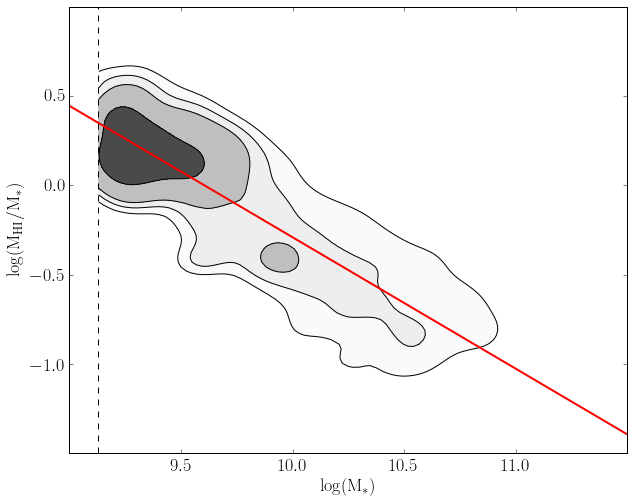

In [12]:
from scipy.optimize import curve_fit
from contours import kde_contour

axis_limits = ((9,11.5,-1.5,1))
x_guide = np.linspace(9,12)

def linear_function(x,m,c):
    return m*x + c

mass = chang_data['lmass50_all']
gas_mass = a70_data['loghimass']
mask = vmax_both
gas_fraction = gas_mass - mass
weights = weighting_both

x, y, w = (u[mask] for u in [mass,gas_fraction,weights])

fill_properties = {'alpha':1}
_ = kde_contour(x,y,weights=w,fill=True,fill_properties=fill_properties,N_max=1000)

plt.axis(axis_limits)
plt.xlabel('$\mathrm{\log(M_*)}$')
plt.ylabel('$\mathrm{\log(M_{HI}/M_*)}$')

from scipy.optimize import curve_fit

def linear_function(x,m,c):
    return m*x + c

x_guide = np.linspace(9,12,100)
p, _ = curve_fit(linear_function,mass[mask],gas_fraction[mask],
                 sigma=1/weighting_both[mask]**0.5,absolute_sigma=False)

_ = plt.plot(x_guide,linear_function(x_guide,*p),'r-',lw=2)

# plot a guideline to the gas fractions limits?
plt.vlines(9.13,axis_limits[2],axis_limits[3],color='k',linestyle='dashed')

plt.savefig('../output_figures/gas_sequence.pdf')

median scatter = 0.19170283218053097


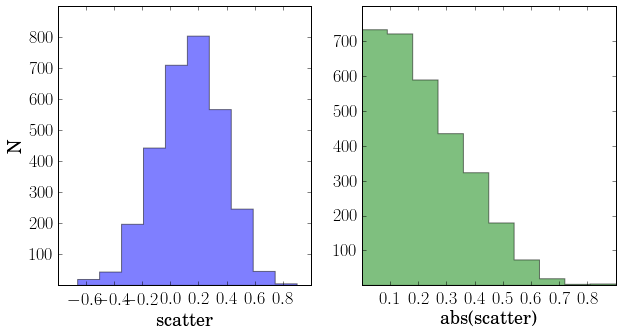

In [13]:
y_expected = linear_function(x,*p)
scatter = y - y_expected
abs_scatter = np.abs(scatter)

fig, axarr = plt.subplots(1,2,figsize=(10,5))
_ = axarr[0].hist(scatter,color='b',alpha=0.5,histtype='stepfilled')
_ = axarr[1].hist(abs_scatter,color='g',alpha=0.5,histtype='stepfilled')
axarr[0].set_xlabel('scatter')
axarr[0].set_ylabel('N')
axarr[1].set_xlabel('abs(scatter)')

print('median scatter = {}'.format(np.median(abs_scatter)))

In [14]:
print('y={}x + {}'.format(*p))

y=-0.7361869845776561x + 7.0710230586509875


In [15]:
# now attempt to plot up the 'SF deficiency' for each of the samples?
from matplotlib.ticker import MaxNLocator

def histogram_stack(x,m_x,bins,x_reference=None,
                    plot_percentiles=False,printout=False,ylims=None):
    
    colors = ['orange','r','m','g','b']
    mlabels = ['1','2','3','4','5+']
    flabels = 'abcde'
    
    fig, axarr = plt.subplots(5,1,figsize=(10,15),sharex=True,sharey=True)
    plt.subplots_adjust(hspace=0,wspace=0)
    if ylims is not None:
        axarr[-1].set_ylim(ylims)
    
    for m in range(5):
        in_m = m_x == m
        ax = axarr[m]
        ax.set_ylabel('normalised \n density')
        ax.text(0.025,0.925,'({}) m={} ($N_{{gal}}$={})'.format(flabels[m],
                                                                mlabels[m],
                                                                len(x[in_m])),
                ha='left',va='top',transform=ax.transAxes)

        if x_reference is not None:
            _ = ax.hist(x_reference,bins=bins,normed=True,
                         color='k',alpha=0.4,histtype='stepfilled')
            _ = ax.hist(x_reference,bins=bins,normed=True,
                         color='k',histtype='step')
        
        _ = ax.hist(x[in_m],bins=bins,normed=True,
                    color=colors[m],histtype='step',lw=3)
        
        ylims = ax.set_ylim()
    for m in range(5):
        ax = axarr[m]
        in_m = m_x == m
        x_lower = np.percentile(x[in_m],16)
        x_median = np.median(x[in_m])
        x_upper = np.percentile(x[in_m],84)
        if plot_percentiles == True:
            for x_ in [x_lower,x_median,x_upper]:
                _ = ax.vlines(x_,ylims[0],ylims[1],
                                color=colors[m],lw=3,linestyle='dotted')
        if printout == True:
            print('{}: lower={}, median={}, upper={}'.format(mlabels[m],
                                                             np.round(x_lower,decimals=2),
                                                             np.round(x_median,decimals=2),
                                                             np.round(x_upper,decimals=2)))
                
    ax.xaxis.set_major_locator(MaxNLocator(nbins=8,prune='both'))
    ax.yaxis.set_major_locator(MaxNLocator(nbins=6,prune='both'))
    
    return fig, axarr

In [16]:
# now attempt to plot up the 'SF deficiency' for each of the samples?
from matplotlib.ticker import MaxNLocator

def histogram_stack(x,m_x,bins,x_reference=None,x_weights=None,reference_weights=None,
                    plot_percentiles=False,printout=False,ylims=None):
    
    colors = ['orange','r','m','g','b']
    mlabels = ['1','2','3','4','5+']
    flabels = 'abcde'
    
    fig, axarr = plt.subplots(5,1,figsize=(10,15),sharex=True,sharey=True)
    plt.subplots_adjust(hspace=0,wspace=0)
    if ylims is not None:
        axarr[-1].set_ylim(ylims)
    
    for m in range(5):
        in_m = m_x == m
        ax = axarr[m]
        ax.set_ylabel('normalised \n density')
        ax.text(0.025,0.925,'({}) m={} ($N_{{gal}}$={})'.format(flabels[m],
                                                                mlabels[m],
                                                                len(x[in_m])),
                ha='left',va='top',transform=ax.transAxes)

        if x_reference is not None:
            _ = ax.hist(x_reference,bins=bins,normed=True,weights=reference_weights,
                         color='k',alpha=0.4,histtype='stepfilled')
            _ = ax.hist(x_reference,bins=bins,normed=True,weights=reference_weights,
                         color='k',histtype='step')
        if x_weights != None:
            _ = ax.hist(x[in_m],bins=bins,normed=True,weights=x_weights[in_m],
                        color=colors[m],histtype='step',lw=3)
        else:
            _ = ax.hist(x[in_m],bins=bins,normed=True,
                        color=colors[m],histtype='step',lw=3)
        
        ylims = ax.set_ylim()
    for m in range(5):
        ax = axarr[m]
        in_m = m_x == m
        x_lower = np.percentile(x[in_m],16)
        x_median = np.median(x[in_m])
        x_upper = np.percentile(x[in_m],84)
        if plot_percentiles == True:
            for x_ in [x_lower,x_median,x_upper]:
                _ = ax.vlines(x_,ylims[0],ylims[1],
                                color=colors[m],lw=3,linestyle='dotted')
        if printout == True:
            print('{}: lower={}, median={}, upper={}'.format(mlabels[m],
                                                             np.round(x_lower,decimals=2),
                                                             np.round(x_median,decimals=2),
                                                             np.round(x_upper,decimals=2)))
                
    ax.xaxis.set_major_locator(MaxNLocator(nbins=8,prune='both'))
    ax.yaxis.set_major_locator(MaxNLocator(nbins=6,prune='both'))
    
    return fig, axarr

In [17]:
completeness_limit = mass_limit_from_redshift(0.05)
mass_complete_a70 = gas_mass >= completeness_limit

in_sample = ((samples['in_spiral']) &
             (samples['axial_ok']) & 
             (samples['in_mass_limit']))

in_ml = (samples['in_mass_limit']) & (mass_complete_a70)

gas_excess = gas_fraction - linear_function(mass,*p)

print('{} spiral galaxies'.format(np.sum(in_sample)))

sample_w_gas = (in_sample) & (mass_complete_a70)
print('--> {} have a70 detections'.format(np.sum(sample_w_gas)))

6520 spiral galaxies
--> 1005 have a70 detections


/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):
/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):
/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


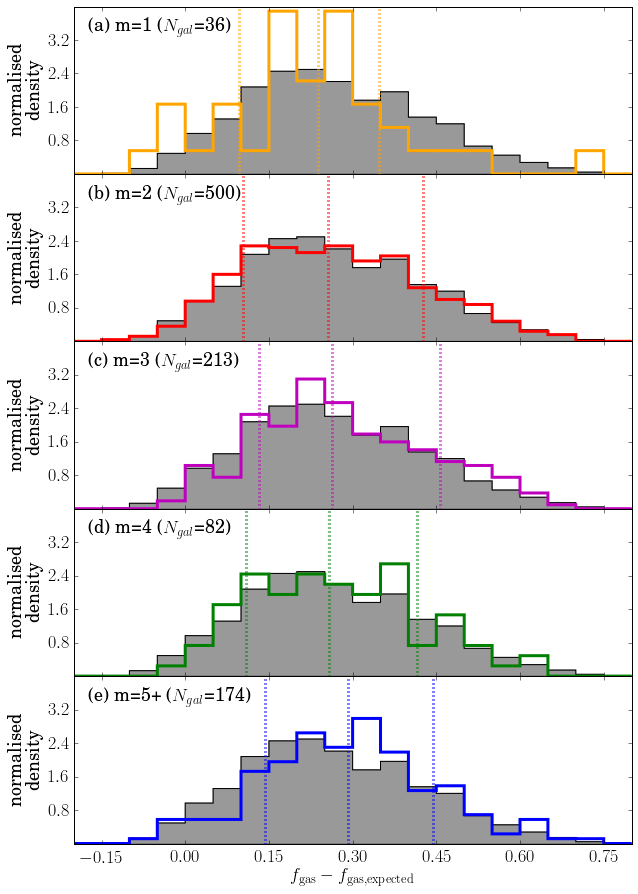

In [31]:
x = gas_excess[sample_w_gas]
m_x = samples['m'][sample_w_gas]
bins = np.linspace(-0.2,0.8,21)
x_reference = gas_excess[(has_a70) & (in_ml)]

fig, axarr = histogram_stack(x,m_x,bins,x_reference,plot_percentiles=True,ylims=(0,4))
axarr[-1].set_xlabel('$f_\mathrm{gas} - f_\mathrm{gas,expected}$')

plt.savefig('../output_figures/gas_excess.pdf')

## Now save the required outputs to a table:

In [20]:
gas_samples = Table()

gas_samples['has_a70'] = has_a70
gas_samples['in_mass_limit'] = mass_complete_a70
gas_samples['in_vmax_limit'] = in_vmax
gas_samples['vmax_weighting'] = vmax_weights
gas_samples['vmax_both'] = vmax_both
gas_samples['vmax_weighting_both'] = weighting_both

#gas_samples.write('../matched_fits/gas_samples.fits')

## what does the completeness look like?

In [21]:
mstar_limited = samples['in_mass_limit']
a70_detected = gas_samples['in_vmax_limit']
in_spiral = (samples['axial_ok']) & (samples['in_spiral'])

in_sample = (mstar_limited) & (a70_detected)
in_spiral_sample = (in_sample) & (in_spiral)

/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


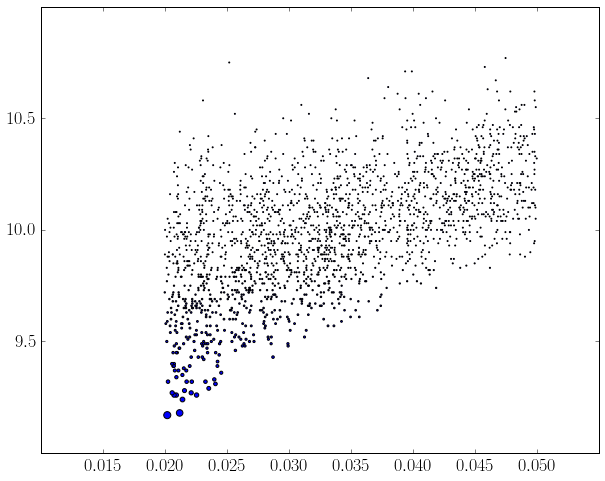

In [22]:
_ = plt.scatter(nsa_data[in_sample]['Z'],a70_data[in_sample]['loghimass'],s=gas_samples[in_sample]['vmax_weighting'])

/home/ppxrh/anaconda3/lib/python3.4/site-packages/astropy/table/column.py:271: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  return self.data.__ne__(other)
/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


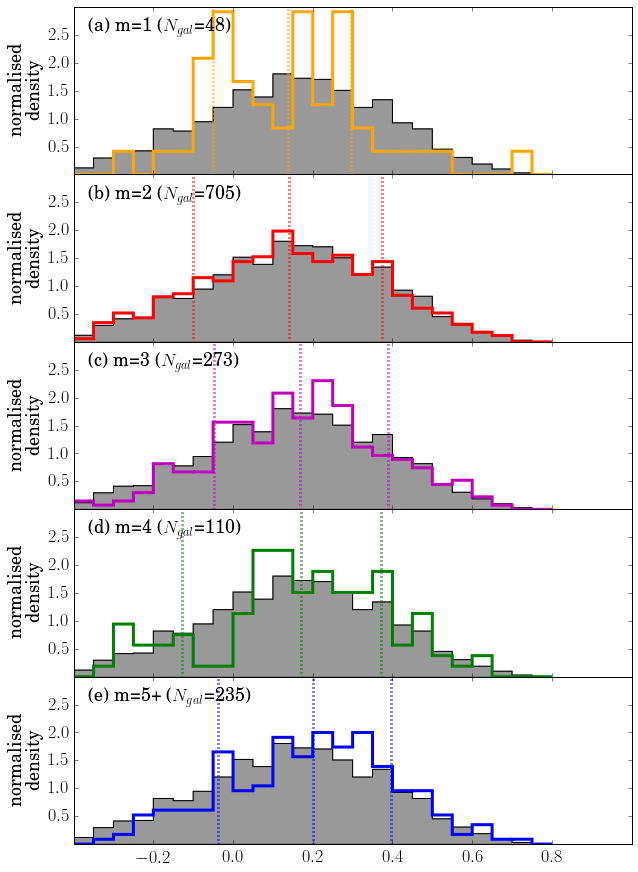

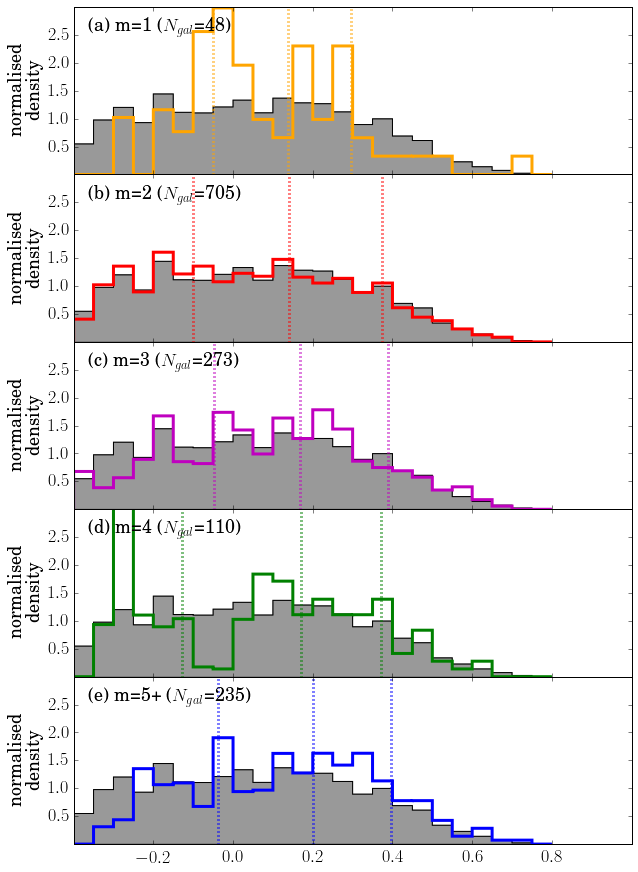

In [30]:
gas_mass = a70_data['loghimass']
weights = gas_samples['vmax_weighting']
m_values = samples['m']
bins = np.linspace(-0.4,0.8,25)
'''
_ = plt.hist(gas_fraction[in_sample],histtype='stepfilled',bins=bins,alpha=0.4,label='raw data')
_ = plt.hist(gas_fraction[in_sample],histtype='step',color='k',bins=bins,lw=2,label='$1/V_{max}$ weighted',
             weights=weights[in_sample])
_ = plt.legend()
'''
_ = histogram_stack(gas_excess[in_spiral_sample],m_values[in_spiral_sample],
                    bins=bins,x_reference=gas_excess[in_sample],
                    plot_percentiles=True)

_ = histogram_stack(gas_excess[in_spiral_sample],m_values[in_spiral_sample],
                    bins=bins,x_reference=gas_excess[in_sample],
                    x_weights=weights[in_spiral_sample],
                    reference_weights=weights[in_sample],
                    plot_percentiles=True)